# Phase 4 Project - Preventing "Panic Selling"
## Natural Language Processing Model for Twitter Reviews on Android, Apple, and Google

Name: Andrew Levinton
Student Pace: Self Pace
Instructor name: Ahbhineet Kukarni

# Tech Stack
- Python
- Pandas
- Matplotlib
- Seaborn
- Scikit-learn
- Natural Language Toolkit

![twitter.jpg](./images/twitter.jpg)

# Business  Problem

In this study, we will be analyzing tweets from twitter to help present findings on sentiment towards product related to Android, Apple, and Google. Many companies want to keep track of public sentiment about various products. Positive sentiment might drive production for creators or inventory management for retailers. It might drive the attention of influencers, news organizations, and consumers. Twitter is a platform where individuals and companies express themselves and have conversations and is full of information about how people feel about particular products.

In the world of stock prices in these high-value tech companies as well as the way media can affect stock prices, the ability to identify a trend of negative sentiment towards the tech companies can cause shareholders to sell their stock at a moments notice. This is the case for retail traders, but even more so for large hedge funds that can dramatically affect a stock price.


## I. Business Understanding
The goals of the business problem will be:

1. Analyze tweets from twitter to gain insight of sentiment towards various products. 
2. Determine which features of tweets best show as the best predict if tweets can be categorized as positive, negative, or neither. 
3. Develop a predictive model that can detect early signs of negative sentiment towards these tech companies on Twitter.

### Business Questions to consider:
1. Do customers have positive or negative sentiment towards Apple, Android, or Google products?
2. Which products might retailers want to keep in their stores to maxmize profit in inventory management?
3. Which products might influencers want to highlight in their posts to gain the most attraction?
4. Which issues about products can lead to a negative sentiment towards these companies?

### The problem with sentiment
Emotions are also relative. Consdier the phrase, "iPhones are better than Android phones." Is this a positive or a negative tweet? It depends! For this reason purposeful data preprocessing will be essential to building data categorization before training it on the model itself. There is a LOT of cleaning that needs to occur, with tweets containing many various symbols and characters that will distract the model from providing an accurate prediction. 




# II. Data Understanding



In [344]:
import pandas as pd
import numpy as np
import random

import os

# machine learning modeling
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

# nlp word processing
import re
from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Pipelines
from imblearn.pipeline import Pipeline, make_pipeline

# SMOTE
from imblearn.over_sampling import SMOTE

plt.style.use('ggplot')

#### Encodings 
I have created a list of encodings (utf-8, latin-1, utf-16) to try. The code attempts to read the CSV file using each encoding until it succeeds or exhausts all the encodings. Once the successful encoding is found, the loop is exited, and the DataFrame (tweet_df) is displayed.

In [345]:
# List of encodings to try
encodings = ['utf-8', 'latin-1', 'utf-16']

# Try different encodings until successful
for encoding in encodings:
    try:
        tweet_df = pd.read_csv('./data/judge-1377884607_tweet_product_company.csv', encoding=encoding)
        print(f'{encoding} worked!')
        break  # Exit the loop if reading is successful
    except UnicodeDecodeError:
        print(f'{encoding} not successful')
        continue  # Continue to the next encoding if decoding error occurs
tweet_df.head()

utf-8 not successful
latin-1 worked!


tweet_text  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

  emotion_in_tweet_is_directed_at  \
0                          iPhone   
1              iPad or iPhone App   
2                            iPad   
3              iPad or iPhone App   
4                          Google   

  is_there_an_emotion_directed_at_a_brand_or_product  
0                                   Negative emotion  
1                                   Positive emotion  
2                                   Positive emotion  
3                                   Negative emotion  
4                                   Positive emotion

Here we will rename the columns for simplicity purposes. This should reduce the strain on workflow.

In [346]:
#rename columns
tweet_df.columns = ['tweet','product','sentiment']
# Display the DataFrame
tweet_df.head()

tweet  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

              product         sentiment  
0              iPhone  Negative emotion  
1  iPad or iPhone App  Positive emotion  
2                iPad  Positive emotion  
3  iPad or iPhone App  Negative emotion  
4              Google  Positive emotion

## Importing new data

After initial EDA on the `tweet_df` dataset, the data for a particular class was severely lacking and more data was added in an attempt to improve the training data of the model, and also a side effect was to make a prettier wordcloud :)

In [347]:
# List of encodings to try
encodings = ['utf-8', 'latin-1', 'utf-16']

# Try different encodings until successful
for encoding in encodings:
    try:
        tweet_df_appl = pd.read_csv('./data/Apple-Twitter-Sentiment-DFE.csv', encoding=encoding)
        #-1: negative, 0: neutral, 1: positive
        print(f'{encoding} worked!')
        break  # Exit the loop if reading is successful
    except UnicodeDecodeError:
        print(f'{encoding} not successful')
        continue  # Continue to the next encoding if decoding error occurs

tweet_df_appl['product'] = 'Apple'
tweet_df_appl = tweet_df_appl[['text','product','sentiment']]
# tweet_df_appl.columns = ['tweet','product','sentiment']
tweet_df_appl.head()

utf-8 not successful
latin-1 worked!


text  \
0                                                                         #AAPL:The 10 best Steve Jobs emails ever...http://t.co/82G1kL94tx   
1                                           RT @JPDesloges: Why AAPL Stock Had a Mini-Flash Crash Today $AAPL #aapl\nhttp://t.co/hGFcjYa0E9   
2                                                                                       My cat only chews @apple cords. Such an #AppleSnob.   
3  I agree with @jimcramer that the #IndividualInvestor should own not trade #Apple #AAPL, it's extended so today's pullback is good to see   
4                                                                                              Nobody expects the Spanish Inquisition #AAPL   

  product sentiment  
0   Apple         3  
1   Apple         3  
2   Apple         3  
3   Apple         3  
4   Apple         3

In [348]:
tweet_df_appl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3886 non-null   object
 1   product    3886 non-null   object
 2   sentiment  3886 non-null   object
dtypes: object(3)
memory usage: 91.2+ KB


## Sentiment target processing

After some digging, the meaning of the '3','5', and '1' labels for sentiment were found. The labels are designated as follows:

- '1': 'negative'
- '3': 'neutral'
- '5': 'positive'

These labels were processed and prepped so that this data could easily be concatenated to the tweet_df dataframe. 

In [349]:
# tweet_df_appl['sentiment'] = tweet_df_appl['sentiment'].apply(lambda x: 3 if x=='3' else 5 if x=='5' else 1 if x=='1' else x)
tweet_df_appl['sentiment'] = tweet_df_appl['sentiment'].apply(lambda x: 'negative' if x == '1'\
                                                              else 'none' if x == '3'\
                                                              else 'positive' if x == '5'\
                                                             else 'unknown')

In [350]:
tweet_df_appl.columns = ['tweet','product','sentiment']

tweet_df = pd.concat([tweet_df,tweet_df_appl])
tweet_df.head()

tweet  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

              product         sentiment  
0              iPhone  Negative emotion  
1  iPad or iPhone App  Positive emotion  
2                iPad  Positive emotion  
3  iPad or iPhone App  Negative emotion  
4              Google  Positive emotion

In [351]:
tweet_df.shape

(12979, 3)

## Checking for missing values

In [352]:
tweet_df.isnull().sum()

tweet           1
product      5802
sentiment       0
dtype: int64

In [353]:
tweet_df['product'].value_counts()

Apple                              4547
iPad                                946
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: product, dtype: int64

## Addressing Product Values

In the dataframe we see a a large amount of missing product values as well as some varying names in the companies. For example, we see that 'Apple' has certain product values like 'iPad' or 'iPhone App' and Google has product values like 'Other Google Product or Service'.

Since we are just interested in analyzing the sentiment towards the companies themselves, the product values are changed to just be associated with Apple, Google, and Android. This is addressed by first filling the product column by writing a function from word text in the assosicated tweets then renaming the rest of the columns that contain the various product contained by these three companies. 

## Functions

The functions shown below are developed to aid in data cleaning and preprocessing. The purpose is to simplify the data to enable a more accurate spread of the data distribution as well as avoid repeated code within the notebook. 

The code provided includes several functions and operations on the tweet_df DataFrame. Here's a brief explanation of each function and operation:

1. `Renaming Sentiment Column Values`: This operation uses a lambda function and string comparisons to rename the values in the 'sentiment' column of the tweet_df DataFrame. It converts values like 'negative emotion' to 'negative', 'positive emotion' to 'positive', and so on.

2. `Renaming Product Column Values`: Similar to the sentiment column renaming, this operation uses a lambda function and string comparisons to rename the values in the 'product' column of the tweet_df DataFrame. It converts various forms of 'iPhone', 'iPad', 'Apple', 'Android', 'Google', and other variations to consistent labels like 'Apple', 'Android', 'Google', and 'Product Unknown' for missing values.

3. `Filling Null and Missing Values`: This operation fills the missing values in the 'product' column with the label 'Product Unknown' using fillna(), and then removes any remaining rows with null values using dropna().

4. `Plot Distribution Function`: This function, plot_distribution, takes a DataFrame (df) and a column name (col_name) as input. It generates a histogram plot of the distribution of values in the specified column. It sets the title, x and y labels, and shows the plot using matplotlib.

5. `Filling Unknown Product Values`: This operation fills the unknown 'product' values in the 'tweet' column of the DataFrame using a lambda function and string checks. It assigns labels like 'Apple', 'Google', 'Android', or 'Unknown' based on the presence of specific keywords in the 'tweet' column.


In [354]:
#renaming sentiment column values
tweet_df['sentiment'] = tweet_df['sentiment'].str.lower().apply(lambda x: 'negative' if x=='negative emotion'\
                                                                           else 'positive' if x=='positive emotion'\
                                                                           else 'none' if x=='no emotion toward brand or product'or x=="i can't tell"\
                                                                           else x)
#renaming product values
tweet_df['product'] = tweet_df['product'].str.lower().apply(lambda x: 'Apple' if x=='iphone' or x=='ipad or iphone app' or x=='other apple product or service' or x=='ipad' or x=='apple'\
                                                                           else 'Android' if x=='android app' or x=='android'\
                                                                           else 'Google' if x=='google'or x=="other google product or service"\
                                                                           else x)
#filling nulls of missing values
tweet_df['product'].fillna('Product Unknown', inplace = True)
tweet_df.dropna(inplace = True)


#function for plotting distributions
def plot_distribution(df, col_name):
    sentiment_counts = df[col_name].value_counts()
    df[col_name].hist(figsize=(10,6))
    plt.title(f'{col_name.capitalize()} Distribution')
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.ylabel('count')
    plt.show()
    

#filling unknown product values
tweet_df['product'] = tweet_df['tweet'].str.lower().apply(lambda x: 'Apple' if 'ipad' in x\
                                                          or 'apple' in x or 'iphone' in x\
                                                          or 'itunes' in x or 'mac' in x\
                                                          or 'macbook' in x\
                                                          else 'Google' if 'google' in x\
                                                          else 'Android' if 'android' in x\
                                                          else 'Unknown')
def save_text_file(df, df_name):
    # Get the current working directory
    current_directory = os.getcwd()

    # Concatenate the text data
    text_data = df['tweet_text_cleaned'].str.cat(sep=' ')

    # Define the file name
    file_name = f'{df_name}.txt'

    # Combine the directory path and file name
    output_file_path = os.path.join(current_directory, file_name)

    # Writing the text to the file
    with open(output_file_path, 'w', encoding='utf-8') as file:
        file.write(text_data)

    print(f"Text data saved to '{output_file_path}'.")

#### Initial Obersvations

We see that we have three columns available in the dataframe:
1. tweet - The text of the tweet. We see that this column contains the "review" or tweet about product from each customer. 
2. product - This column represents the product or brand from the tweet.
3. sentiment - This column represents the sentiment or emotion toward the brand or product.

The **sentiment** will be our target column. 

#### Missing Values
It appears that the product column may contains a large amount of missing values. It will be important to explore this column and see if those values can be filled in or need to be dropped.

### Observing the target column

Here we will look at the distribution of the target column. It will be important to explore the labels to see if any type of under or over sampling may be necessary during the modeling phase of this study.

Observing the distribution of the target column in sentiment prediction for NLP is important because it helps identify class imbalances, understand data quality, and select appropriate evaluation metrics and models. By calculating frequency counts, visualizing the distribution, and computing summary statistics, we can gain insights into class imbalances, anomalies, and the overall characteristics of the data. This information guides us in addressing imbalances, making data-driven decisions, and improving model performance.

In [355]:
tweet_df['sentiment'].value_counts()

none        7706
positive    3401
negative    1789
unknown       82
Name: sentiment, dtype: int64

Previously, before the second dataframe was added, we had a very small sample size of negative tweets making the models run on them very spotty. This did not improve the model as much as I would have liked, but I had to run with it. 

We removed the 'unknown' category as it only omitted a very small percentage of the dataframe, and our target was the three classes. 

In [356]:
tweet_df = tweet_df[(tweet_df['sentiment'] == 'none') |\
                    (tweet_df['sentiment'] == 'positive') |\
                    (tweet_df['sentiment'] == 'negative')]

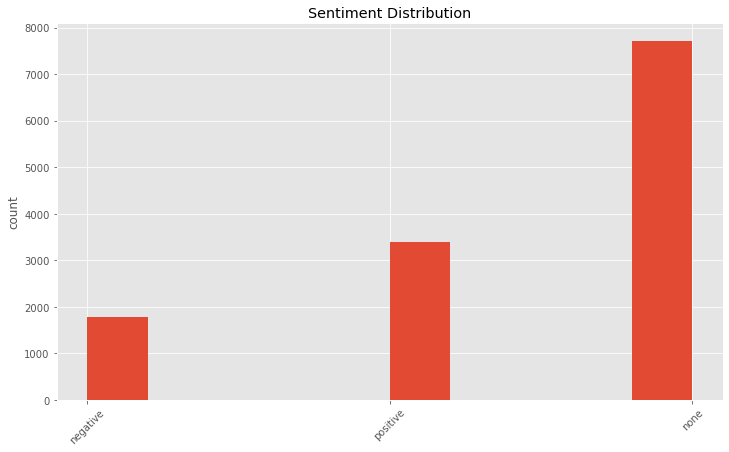

In [357]:
plot_distribution(tweet_df, 'sentiment')

## Understanding Class Imbalance
By examining the distribution of the target column, you can determine if there is a class imbalance issue. Class imbalance occurs when one class is significantly more prevalent than the others. This can impact the model's performance, as it may become biased towards the majority class. Identifying class imbalance early on helps in choosing appropriate strategies to handle it.

## SMOTE
SMOTE (Synthetic Minority Over-sampling Technique) is a popular technique used in the context of imbalanced classification problems. Imbalanced classification occurs when the distribution of classes in the training data is highly skewed, meaning one class (the minority class) has significantly fewer samples compared to the other class(es) (the majority class).

The main use case and purpose of SMOTE are to address the imbalanced class distribution and improve the performance of machine learning models, especially in scenarios where the minority class is of particular interest and misclassification of the minority class is more critical.

## Model Selection and Evaluation
The distribution of the target column influences the choice of evaluation metrics and the selection of an appropriate model. Understanding the distribution allows for better evaluation and comparison of different models, as well as assessing their effectiveness in capturing the desired sentiment patterns.

## Observing the product column

In [14]:
tweet_df.head(20)

tweet  product sentiment
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...    Apple  negative
1   @jessedee Know about @fludapp ? Awesome iPad/i...    Apple  positive
2   @swonderlin Can not wait for #iPad 2 also. The...    Apple  positive
3   @sxsw I hope this year's festival isn't as cra...    Apple  negative
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   Google  positive
5   @teachntech00 New iPad Apps For #SpeechTherapy...    Apple      none
7   #SXSW is just starting, #CTIA is around the co...   Google  positive
8   Beautifully smart and simple idea RT @madebyma...    Apple  positive
9   Counting down the days to #sxsw plus strong Ca...    Apple  positive
10  Excited to meet the @samsungmobileus at #sxsw ...  Android  positive
11  Find &amp; Start Impromptu Parties at #SXSW Wi...  Android  positive
12  Foursquare ups the game, just in time for #SXS...  Android  positive
13  Gotta love this #SXSW Google Calendar featurin...   Google  positive
14  Great #sxsw ipad app from @madebymany: http://...    Apple  positive
15  haha, awesomely rad iPad app by @madebymany ht...    Apple  positive
16  Holler Gram for iPad on the iTunes App Store -...    Apple      none
17  I just noticed DST is coming this weekend. How...    Apple  negative
18  Just added my #SXSW flights to @planely. Match...    Apple  positive
19  Must have #SXSW app! RT @malbonster: Lovely re...    Apple  positive
20  Need to buy an iPad2 while I'm in Austin at #s...    Apple  positive

With the addition of the apple dataframe, we produced a somewhat high class imbalance of the product dataframe. We still will analyze Google and Android, but on a smaller scale. 

In [341]:
tweet_df['product'].value_counts()

Apple      9227
Google     2417
Unknown     905
Android     347
Name: product, dtype: int64

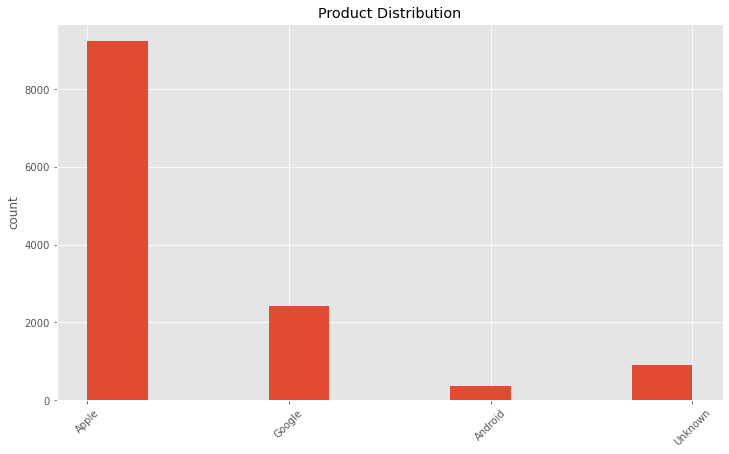

In [343]:
plot_distribution(tweet_df, 'product')

## Sentiment breakdown by target
Analyzing the sentiment breakdown by product is crucial for assessing product performance, identifying issues, and designing targeted improvement strategies. By evaluating the sentiment distribution for each product, organizations can understand customer satisfaction levels, pinpoint areas of improvement, and allocate resources effectively. This breakdown aids decision-making, allows for benchmarking against competitors, and helps in prioritizing efforts for product development, marketing, and customer support. By leveraging sentiment breakdown data, businesses can enhance customer satisfaction, address challenges, and achieve overall success.

In [359]:
# sentiment breakdown by target

grouped = tweet_df.groupby(['product', 'sentiment']).count().reset_index()
grouped

product sentiment  tweet
0   Android  negative     16
1   Android      none    194
2   Android  positive    137
3     Apple  negative   1622
4     Apple      none   5044
5     Apple  positive   2561
6    Google  negative    129
7    Google      none   1620
8    Google  positive    668
9   Unknown  negative     22
10  Unknown      none    848
11  Unknown  positive     35

In [18]:
grouped_android = grouped[grouped['product'] == 'Android'][['sentiment','tweet']]
grouped_Apple = grouped[grouped['product'] == 'Apple'][['sentiment','tweet']]
grouped_Google = grouped[grouped['product'] == 'Google'][['sentiment','tweet']]
grouped_Unknown = grouped[grouped['product'] == 'Unknown'][['sentiment','tweet']]

In [19]:
print("Grouped Android:\n ")
print(grouped_android);

print("Grouped Apple: \n")
print(grouped_Apple);

print("Grouped Google: \n")
print(grouped_Google);

print("Grouped Unknown:\n ")
print(grouped_Unknown);

Grouped Android:
 
  sentiment  tweet
0  negative     16
1      none    194
2  positive    137
Grouped Apple: 

  sentiment  tweet
3  negative   1622
4      none   5044
5  positive   2561
Grouped Google: 

  sentiment  tweet
6  negative    129
7      none   1620
8  positive    668
Grouped Unknown:
 
   sentiment  tweet
9   negative     22
10      none    848
11  positive     35


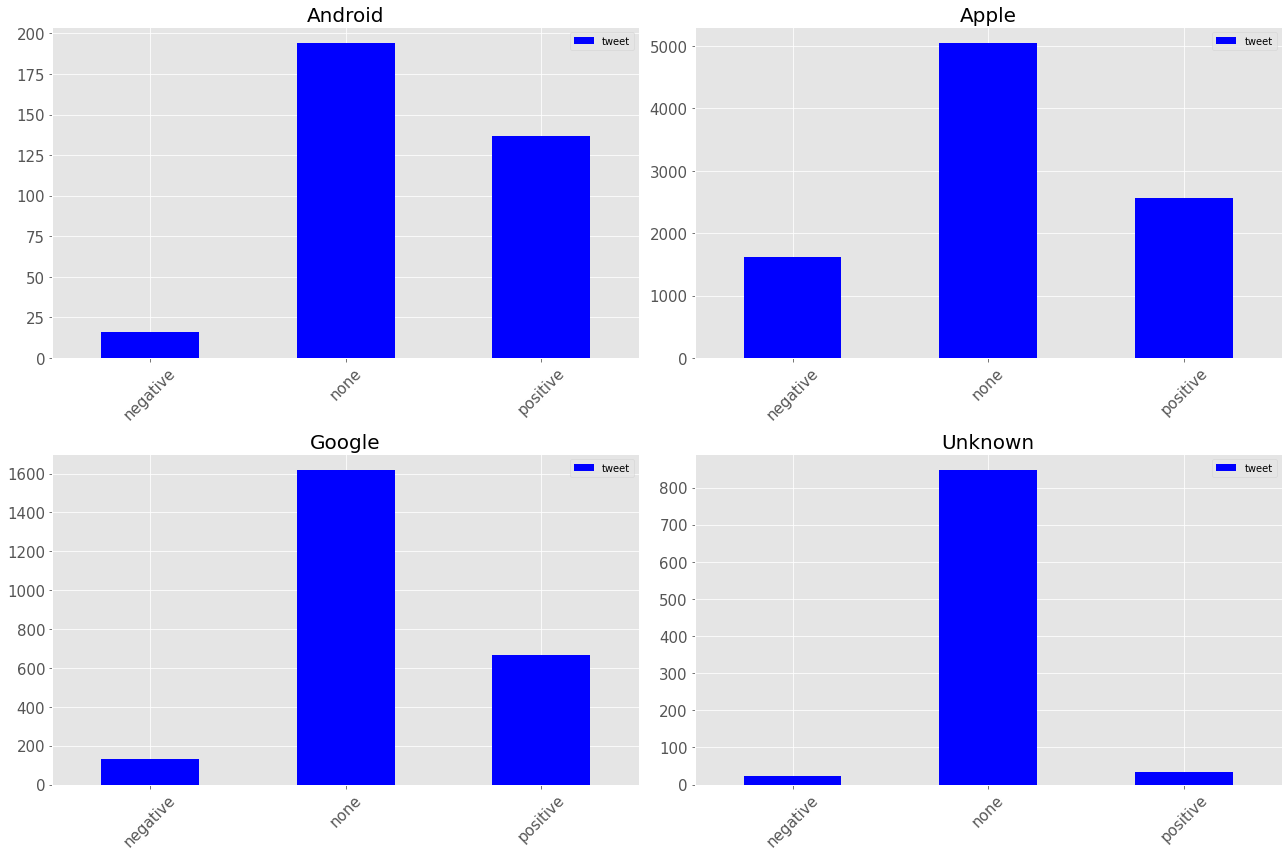

In [20]:
products = [grouped_android, grouped_Apple, grouped_Google, grouped_Unknown]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

axes = axes.flatten()

category_names = ['Android', 'Apple', 'Google', 'Unknown']

xticks = ['negative', 'none', 'positive'] 

for i, category in enumerate(products):
    ax = axes[i]
    category.plot(kind='bar', ax=ax, color='b')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(category_names[i], fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xticklabels(xticks)  

plt.tight_layout()
plt.show()


# Data Preparation

## I. Text Cleaning - Word Tokenization

Tokenization is used in natural language processing to split paragraphs and sentences into smaller units that can be more easily assigned meaning.   

The first step of the NLP process is gathering the data (a sentence) and breaking it into understandable parts (words).


## Text Before Cleaning:
###  "~RT~ ~@LaurieShook:~ I~'~m look~ing~ forward ~to the~ ~#~SMCDallas pre ~#SXSW~ party Wed~.,~ ~and~ hop~ing~ I~'~ll win ~an~ ~#iPad~ result~ing~ ~from~ ~my~ shameless promotion~.~  ~#~ChevySMC"

## Text After Cleaning:
### "im look forward smcdallas pre party wed hop ill win result shameless promotion chevysmc"

#### Functions

This function is designed to convert parts-of-speech tags from the Treebank format to the corresponding format used by WordNet, a lexical database for the English language. WordNet categorizes words into different parts of speech such as nouns, verbs, adjectives, and adverbs.

In [360]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

sw = stopwords.words('english')
'''Initializes the sw variable with a list of stopwords from the NLTK library. 
Stopwords are commonly used words (such as articles, prepositions, etc.) 
that often don't carry much meaning in a text and can be safely ignored during analysis.'''

sw.extend(['link', 'rt', 'sxsw', 'get', 'google', 'apple', 'iphone', 'ipad'])
'''Additional words ('link', 'rt', 'sxsw', 'get', 'google', 'apple', 'iphone', 'ipad') 
are appended to the list of stopwords. These words are typically specific to the context 
or domain and are considered irrelevant for analysis.'''

punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~“!#'
'''Defines a string containing various 
punctuation marks and special characters that need 
to be removed from the text.'''

no_accents_re = re.compile('^[a-z]+$')
'''This line compiles a regular expression pattern that matches 
words consisting only of lowercase letters without any accents.'''

accents = ['á', 'â', 'ã', 'à', 'å', 'ª', 'ç', 'è', '¼', '¾', 'î', 'ï', 'ì', 'ó', 'ö', 'ð', 'ü', 'ù', 'û', 'ý']
'''This list contains various accent characters that need to be removed from the words.'''

twitter_re = re.compile('[@][a-zA-Z]*')
'''Compile a regular expression pattern that matches strings consisting only of digits.'''

num_re = re.compile('^\d+$')
'''The text string (txt) is split into a list of words based on whitespace.'''

def remove_punctuation(text, punctuation):
    for char in punctuation:
        text = text.replace(char, '')
    return text

def remove_twitter_handles(text, twitter_re):
    words = text.split()
    filtered_words = []
    for word in words:
        if not twitter_re.match(word):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def remove_numbers(text, num_re):
    words = text.split()
    filtered_words = []
    for word in words:
        if not num_re.match(word):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def remove_accents(text, accents, no_accents_re):
    words = text.split()
    filtered_words = []
    for word in words:
        if no_accents_re.match(word):
            filtered_words.append(word)
    return ' '.join(filtered_words)

def txt_clean(txt, stop_words=sw):
    t = txt.lower()
    t = remove_punctuation(t, punctuation)
    t = remove_twitter_handles(t, twitter_re)
    t = remove_numbers(t, num_re)
    t = remove_accents(t, accents, no_accents_re)
    t = t.split()
    t = [w for w in t if w not in stop_words and w]
    t = pos_tag(t)
    t = [(w[0], get_wordnet_pos(w[1])) for w in t]
    lem = WordNetLemmatizer()
    t = [lem.lemmatize(w[0], w[1]) for w in t]
    return ' '.join(t)

tweet_df['tweet_text_cleaned'] = tweet_df['tweet'].map(txt_clean)


In [361]:
pd.set_option('display.max_colwidth', None)

In [362]:
tweet_df.head()

tweet  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

  product sentiment  \
0   Apple  negative   
1   Apple  positive   
2   Apple  positive   
3   Apple  negative   
4  Google  positive   

                                                                             tweet_text_cleaned  
0                                          hr tweet riseaustin dead need upgrade plugin station  
1            know awesome ipadiphone app youll likely appreciate design also theyre give free t  
2                                                                                wait also sale  
3                                                       hope year festival isnt crashy year app  
4  great stuff fri marissa mayer tim oreilly tech booksconferences amp matt mullenweg wordpress

## II. Data Preprocessing - Train Test Split
The train-test split is a process used in machine learning to evaluate model performance. It involves dividing a dataset into two parts: a training set and a testing set. The training set is used to train the model, while the testing set is used to assess its performance on unseen data. The process includes randomizing the dataset, selecting a split ratio, dividing the data into the two subsets, training the model on the training set, and evaluating its performance on the testing set. This approach helps estimate how well the model will generalize to new, unseen data and allows for model optimization before real-world deployment.

Train-test split is typically performed at the beginning of the machine learning process to avoid data leakage. Data leakage refers to a situation where information from the testing set inadvertently influences the training process or model evaluation, leading to overly optimistic performance estimates. It can result in models that generalize poorly to new, unseen data.

Machine Learning models require numeric values, so we will replace them. `Positive` will receive the numeric label `0`, `Negative` will receive the numeric label `1`, and `none` will receive the numeric label `2`.

In [24]:
tweet_df['sentiment'] = tweet_df['sentiment'].apply(lambda x: 0 if x=='positive'\
                                                    else 1 if x=='negative'\
                                                    else 2 if x=='none'\
                                                   else x)

In [25]:
tweet_df.head()

tweet  \
0              .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1  @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                              @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                           @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
4          @sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)   

  product  sentiment  \
0   Apple          1   
1   Apple          0   
2   Apple          0   
3   Apple          1   
4  Google          0   

                                                                             tweet_text_cleaned  
0                                          hr tweet riseaustin dead need upgrade plugin station  
1            know awesome ipadiphone app youll likely appreciate design also theyre give free t  
2                                                                                wait also sale  
3                                                       hope year festival isnt crashy year app  
4  great stuff fri marissa mayer tim oreilly tech booksconferences amp matt mullenweg wordpress

In [26]:
tweet_df['sentiment'].value_counts()

2    7706
0    3401
1    1789
Name: sentiment, dtype: int64

#### Split data into x and y

In [27]:
X = tweet_df['tweet_text_cleaned']
y = tweet_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X, y, random_state = 42, test_size = 0.25)

## Tokenization
Tokenization is a fundamental step in Natural Language Processing (NLP) that involves breaking down text into smaller units called tokens. These tokens can be words, sentences, or even subword units, depending on the level of granularity required for a specific NLP task.

## Plotting Unigrams

In [28]:
#initialize count vectorizer for unigrams
vectorizer = CountVectorizer(ngram_range = (1,1))
#fit_transform the vectorizer to the data
X_count = vectorizer.fit_transform(X)

X_count = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(vectorizer.vocabulary_)
X_count.set_index(y.index, inplace=True)

all_uni_labels = X_count.sum().sort_values(ascending = False)[0:10]
uni_positive = X_count[tweet_df['sentiment'] == 0].sum().sort_values(ascending = False)[:10] #positive = 0
uni_negative = X_count[tweet_df['sentiment'] == 1].sum().sort_values(ascending = False)[:10] #negative = 1
uni_no_label = X_count[tweet_df['sentiment'] == 2].sum().sort_values(ascending = False)[:10] #none=2

sentiments_uni = [all_uni_labels, uni_no_label, uni_positive, uni_negative]

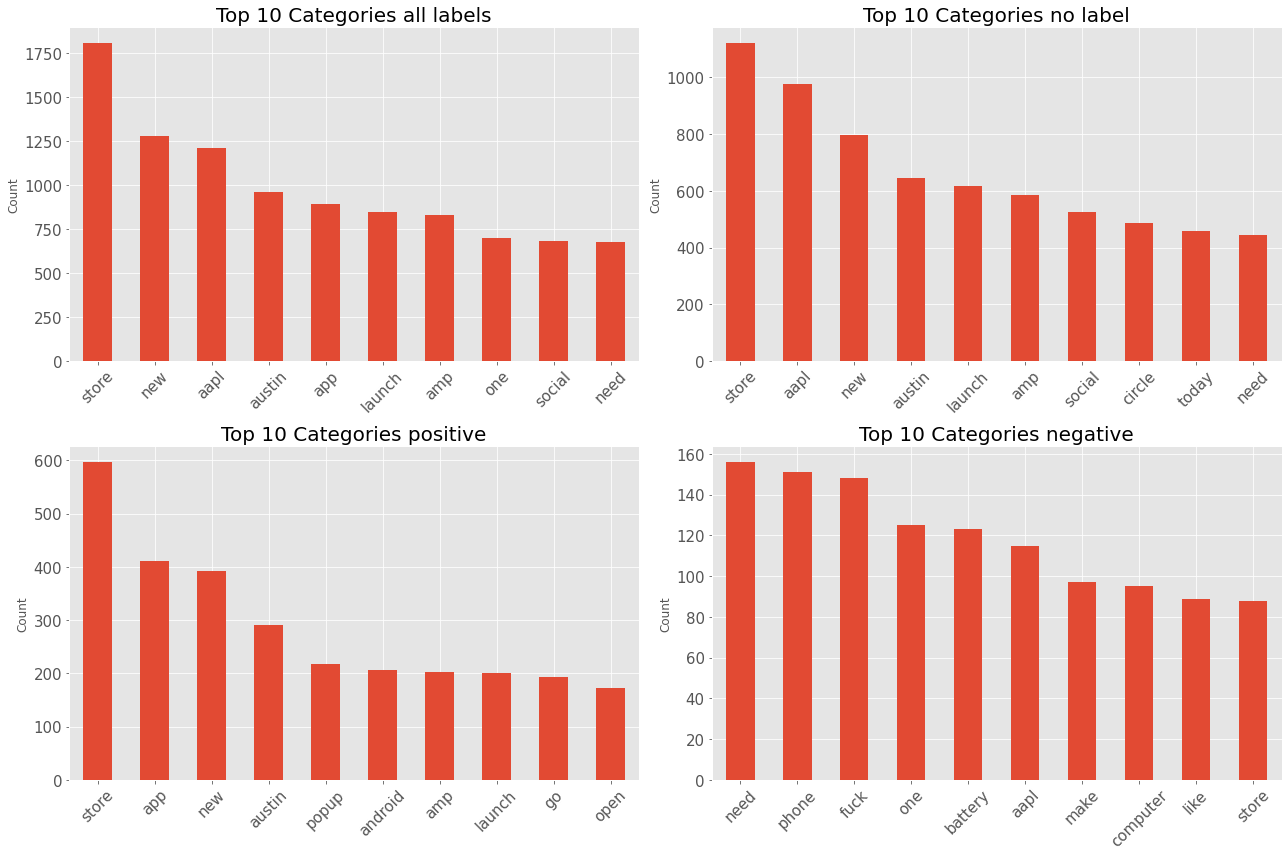

In [29]:
sentiments_uni = [all_uni_labels, uni_no_label, uni_positive, uni_negative]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

axes = axes.flatten()

category_names = ['all labels', 'no label', 'positive', 'negative']


for i, category in enumerate(sentiments_uni):
    ax = axes[i] 
    category.plot(kind='bar', ax=ax)
    ax.set_ylabel('Count')
    ax.set_title(f'Top 10 Categories {category_names[i]}', fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

plt.tight_layout() 
plt.show()

## Plotting Bigrams

In [30]:
cv = CountVectorizer(ngram_range = (2,2))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

all_bi_labels = X_count.sum().sort_values(ascending = False)[0:10]
bi_positive = X_count[tweet_df['sentiment'] == 0].sum().sort_values(ascending = False)[0:10] #positive = 0
bi_negative = X_count[tweet_df['sentiment'] == 1].sum().sort_values(ascending = False)[0:10] #negative = 1
bi_no_label = X_count[tweet_df['sentiment'] == 2].sum().sort_values(ascending = False)[0:10] #none=2

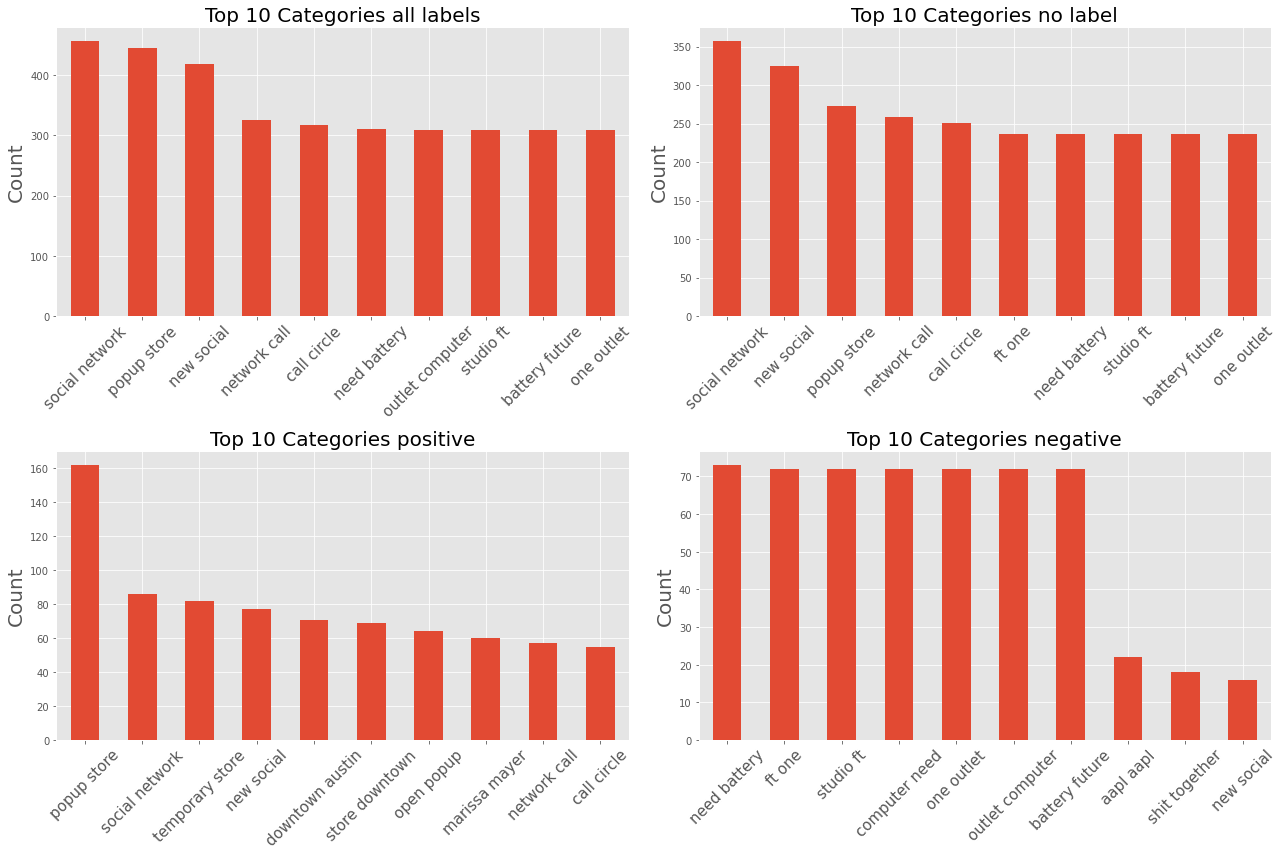

In [31]:
sentiments_bi = [all_bi_labels, bi_no_label, bi_positive, bi_negative]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

axes = axes.flatten()

category_names = ['all labels', 'no label', 'positive', 'negative']


for i, category in enumerate(sentiments_bi):
    ax = axes[i] 
    category.plot(kind='bar', ax=ax) 
    ax.set_ylabel('Count', fontsize=20)
    ax.set_title(f'Top 10 Categories {category_names[i]}', fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)

plt.tight_layout() 
plt.show()

## Plotting Trigrams

In [32]:
cv = CountVectorizer(ngram_range = (3,3))
X_count = cv.fit_transform(X)
X_count  = pd.DataFrame.sparse.from_spmatrix(X_count)
X_count.columns = sorted(cv.vocabulary_)
X_count.set_index(y.index, inplace=True)

all_tri_labels = X_count.sum().sort_values(ascending = False)[0:10]
tri_positive = X_count[tweet_df['sentiment'] == 0].sum().sort_values(ascending = False)[0:10] #positive = 0
tri_negative = X_count[tweet_df['sentiment'] == 1].sum().sort_values(ascending = False)[0:10] #negative = 1
tri_no_label = X_count[tweet_df['sentiment'] == 2].sum().sort_values(ascending = False)[0:10] #none=2

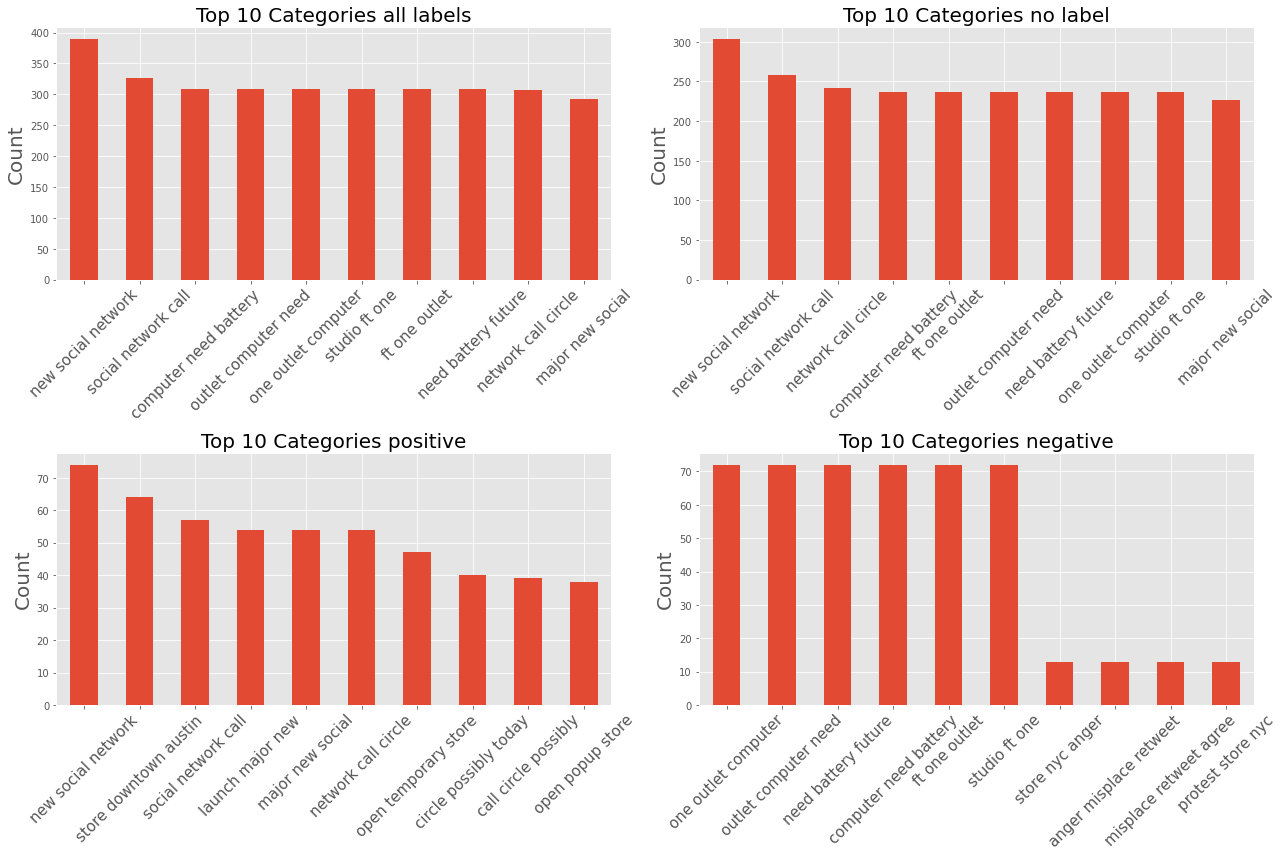

In [33]:
sentiments_bi = [all_tri_labels, tri_no_label, tri_positive, tri_negative]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 12))

axes = axes.flatten()

category_names = ['all labels', 'no label', 'positive', 'negative']


for i, category in enumerate(sentiments_bi):
    ax = axes[i] 
    category.plot(kind='bar', ax=ax) 
    ax.set_ylabel('Count', fontsize=20)
    ax.set_title(f'Top 10 Categories {category_names[i]}', fontsize=20)
    ax.tick_params(axis='x', rotation=45, labelsize=15)

plt.tight_layout() 
plt.show()

## Count Vectorizer

In [100]:
cv = CountVectorizer(ngram_range = (1,1))
X_t_vec_count = cv.fit_transform(X_t)
X_t_vec_count  = pd.DataFrame.sparse.from_spmatrix(X_t_vec_count)
X_t_vec_count.columns = sorted(cv.vocabulary_)
X_t_vec_count.set_index(y_t.index, inplace=True)

X_val_vec_count = cv.transform(X_val)
X_val_vec_count  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_count)
X_val_vec_count.columns = sorted(cv.vocabulary_)
X_val_vec_count.set_index(y_val.index, inplace=True)

X_t_vec_count.sum(axis = 0).sort_values(ascending = False)[:16]

store      1328
new         982
aapl        910
austin      722
app         669
launch      650
amp         634
one         535
social      530
need        506
circle      469
today       469
android     454
popup       449
go          441
via         425
dtype: int64

In [84]:
cv = CountVectorizer(ngram_range = (2,2))
X_t_vec_count_bi = cv.fit_transform(X_t)
X_t_vec_count_bi  = pd.DataFrame.sparse.from_spmatrix(X_t_vec_count_bi)
X_t_vec_count_bi.columns = sorted(cv.vocabulary_)
X_t_vec_count_bi.set_index(y_t.index, inplace=True)

X_val_vec_count_bi = cv.transform(X_val)
X_val_vec_count_bi  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_count_bi)
X_val_vec_count_bi.columns = sorted(cv.vocabulary_)
X_val_vec_count_bi.set_index(y_val.index, inplace=True)

X_t_vec_count_bi.sum(axis = 0).sort_values(ascending = False)[:16]

social network     355
popup store        332
new social         322
network call       251
call circle        240
one outlet         234
battery future     234
computer need      234
outlet computer    234
ft one             234
need battery       234
studio ft          234
major new          218
launch major       213
aapl aapl          206
possibly today     178
dtype: int64

In [110]:
cv = CountVectorizer(ngram_range = (3,3))
X_t_vec_count_tri = cv.fit_transform(X_t)
X_t_vec_count_tri  = pd.DataFrame.sparse.from_spmatrix(X_t_vec_count_tri)
X_t_vec_count_tri.columns = sorted(cv.vocabulary_)
X_t_vec_count_tri.set_index(y_t.index, inplace=True)

X_val_vec_count_tri = cv.transform(X_val)
X_val_vec_count_tri  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_count_tri)
X_val_vec_count_tri.columns = sorted(cv.vocabulary_)
X_val_vec_count_tri.set_index(y_val.index, inplace=True)

X_t_vec_count_tri.sum(axis = 0).sort_values(ascending = False)[:16]

new social network        302
social network call       251
network call circle       235
studio ft one             234
ft one outlet             234
outlet computer need      234
computer need battery     234
one outlet computer       234
need battery future       234
major new social          217
launch major new          213
call circle possibly      174
circle possibly today     172
anger misplace retweet    114
misplace retweet agree    114
store nyc anger           114
dtype: int64

## TFIDF Vectorizer

In [92]:
tfidf = TfidfVectorizer(ngram_range = (1,1))
X_t_vec_tfidf = tfidf.fit_transform(X_t)
X_t_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_t_vec_tfidf)
X_t_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_t_vec_tfidf.set_index(y_t.index, inplace = True)

X_val_vec_tfidf = tfidf.transform(X_val)
X_val_vec_tfidf  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_tfidf)
X_val_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_val_vec_tfidf.set_index(y_val.index, inplace=True)

X_t_vec_tfidf.sum(axis = 0).sort_values(ascending = False)[:16]

store      271.243608
new        195.041960
aapl       183.777520
austin     165.821743
launch     163.231807
app        140.326152
one        135.052512
social     134.587046
need       132.549141
circle     131.014023
popup      126.179037
amp        120.857879
today      117.851592
open       116.978654
network    109.291619
via        109.100597
dtype: float64

In [93]:
tfidf = TfidfVectorizer(ngram_range = (2,2))
X_t_vec_tfidf_bi = tfidf.fit_transform(X_t)
X_t_vec_tfidf_bi = pd.DataFrame.sparse.from_spmatrix(X_t_vec_tfidf_bi)
X_t_vec_tfidf_bi.columns = sorted(tfidf.vocabulary_)
X_t_vec_tfidf_bi.set_index(y_t.index, inplace = True)

X_val_vec_tfidf_bi = tfidf.transform(X_val)
X_val_vec_tfidf_bi  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_tfidf_bi)
X_val_vec_tfidf_bi.columns = sorted(tfidf.vocabulary_)
X_val_vec_tfidf_bi.set_index(y_val.index, inplace=True)

X_t_vec_tfidf_bi.mean(axis = 0).sort_values(ascending = False)[:16]

social network     0.009277
computer need      0.009144
one outlet         0.009144
battery future     0.009144
outlet computer    0.009144
need battery       0.009144
ft one             0.009144
studio ft          0.009144
new social         0.008646
popup store        0.008153
network call       0.007351
call circle        0.007077
major new          0.006561
launch major       0.006478
possibly today     0.005620
circle possibly    0.005596
dtype: float64

In [94]:
tfidf = TfidfVectorizer(ngram_range = (3,3))
X_t_vec_tfidf_tri = tfidf.fit_transform(X_t)
X_t_vec_tfidf_tri = pd.DataFrame.sparse.from_spmatrix(X_t_vec_tfidf_tri)
X_t_vec_tfidf_tri.columns = sorted(tfidf.vocabulary_)
X_t_vec_tfidf_tri.set_index(y_t.index, inplace = True)

X_val_vec_tfidf_tri = tfidf.transform(X_val)
X_val_vec_tfidf_tri  = pd.DataFrame.sparse.from_spmatrix(X_val_vec_tfidf_tri)
X_val_vec_tfidf_tri.columns = sorted(tfidf.vocabulary_)
X_val_vec_tfidf_tri.set_index(y_val.index, inplace=True)

X_t_vec_tfidf_tri.sum(axis = 0).sort_values(ascending = False)[:16]

outlet computer need      95.530100
studio ft one             95.530100
need battery future       95.530100
ft one outlet             95.530100
computer need battery     95.530100
one outlet computer       95.530100
new social network        82.778818
social network call       73.247177
network call circle       69.777197
major new social          65.285982
launch major new          64.646487
call circle possibly      55.283790
circle possibly today     54.988682
anger misplace retweet    40.193342
store nyc anger           40.193342
misplace retweet agree    40.193342
dtype: float64

# Word Cloud Data Prep

In [40]:
tweet_df['tweet_text_cleaned']

0                                               hr tweet riseaustin dead need upgrade plugin station
1                 know awesome ipadiphone app youll likely appreciate design also theyre give free t
2                                                                                     wait also sale
3                                                            hope year festival isnt crashy year app
4       great stuff fri marissa mayer tim oreilly tech booksconferences amp matt mullenweg wordpress
                                                    ...                                             
3881                                via fc warm social medium hire social medium guru la finally twe
3882                                                                           avocado emoji may ask
3883                                        could agree great thing happen appleandibm ibmandtwitter
3884                          photo longer download automatically laptop sync support unhel

### Writing all cleaned text as one string

In [41]:
tweet_df['tweet_text_cleaned'].str.cat(sep = ' ')

'hr tweet riseaustin dead need upgrade plugin station know awesome ipadiphone app youll likely appreciate design also theyre give free t wait also sale hope year festival isnt crashy year app great stuff fri marissa mayer tim oreilly tech booksconferences amp matt mullenweg wordpress new apps speechtherapy communication showcased conference iear edchat asd start ctia around corner googleio hop skip jump good time android fan beautifully smart simple idea write hollergram app httpbitlyieavob counting day plus strong canadian dollar mean stock gear excited meet show sprint galaxy still run android fail find amp start impromptu party httpbitlygvlrin cant wait til android app come foursquare ups game time still prefer far best look android app date gotta love calendar feature top party show case check via gthttpbitlyaxzwxb great app haha awesomely rad app httpbitlyhtdfim hollergram holler gram itunes app store via noticed dst come weekend many user hour late come sunday morning added fligh

In [42]:
tweet_df_pos = tweet_df[tweet_df['sentiment'] == 0]
tweet_df_neg = tweet_df[tweet_df['sentiment'] == 1]
tweet_df_neu = tweet_df[tweet_df['sentiment'] == 2]

### Saving as txt file

In [173]:
save_text_file(tweet_df, 'all_tweet_text')

Text data saved to 'C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_4\Phase_4_Project_NLP-Twitter-Sentiment\all_tweet_text.txt'.


In [174]:
save_text_file(tweet_df_pos, 'positive_tweet_text')

Text data saved to 'C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_4\Phase_4_Project_NLP-Twitter-Sentiment\positive_tweet_text.txt'.


In [175]:
save_text_file(tweet_df_neg, 'negative_tweet_text')

Text data saved to 'C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_4\Phase_4_Project_NLP-Twitter-Sentiment\negative_tweet_text.txt'.


In [176]:
save_text_file(tweet_df_neu, 'neutral_tweet_text')

Text data saved to 'C:\Users\alevi\Documents\Flatiron\dsc-data-science-env-config\Course_Folder\Phase_4\Phase_4_Project_NLP-Twitter-Sentiment\neutral_tweet_text.txt'.


# IV. Modeling 

## Baseline: Shallow Multinomial Naive Bayes

A Multinomial Naive Bayes model is a probabilistic classification algorithm commonly used in natural language processing (NLP) tasks. It is an extension of the Naive Bayes algorithm, which assumes that features (words in NLP) are conditionally independent given the class label.

Explanation of Multinomial Naive Bayes:

- `Probability Model`:
In Multinomial Naive Bayes, we model the probability of observing a document (sequence of words) given a class label. The document is represented as a bag-of-words, which means the order of words is disregarded, and only the frequency of each word matters.

- `Feature Representation`:
In NLP tasks, we often use a bag-of-words representation, where each document is represented as a vector of word counts. The elements of this vector are the frequencies of each word in the document.

- `Conditional Independence`:
The "naive" assumption in Naive Bayes is that the features (word counts) are conditionally independent given the class label. In NLP, this implies that the occurrence of one word does not affect the occurrence of other words in the same document, given the class label.

- `Parameter Estimation`:
To build a Multinomial Naive Bayes model, we estimate the probabilities of observing each word in the vocabulary given a specific class. These probabilities are learned from the training data, and they represent the likelihood of seeing each word in documents of a particular class.

Justification for using Multinomial Naive Bayes in NLP:

- `Efficiency and Scalability`:
Multinomial Naive Bayes is computationally efficient and scales well to large datasets and high-dimensional feature spaces. In NLP, where the vocabulary can be extensive, this efficiency is beneficial.

- `Good Performance with Sparse Data`:
NLP data often results in a sparse feature representation because most documents contain only a small fraction of the entire vocabulary. Multinomial Naive Bayes handles sparse data effectively and can still make reasonably accurate predictions.

- `Text Classification`:
In many NLP tasks, like sentiment analysis, spam detection, and document categorization, Multinomial Naive Bayes has been shown to perform well and achieve competitive results.

- `Handling Multiple Classes`:
Multinomial Naive Bayes can handle more than two classes (multiclass classification) with minimal additional computational cost. This makes it suitable for tasks involving multiple categories or labels.

- `Reasonable Assumption for NLP`:
The independence assumption, though simplistic, often works surprisingly well in NLP tasks. While words in natural language are not entirely independent, the conditional independence assumption captures some level of correlation between words and allows for a straightforward and interpretable model.

## Confusion matrix evaluation for False Negatives - Recall

- **Recall**, also known as sensitivity or true positive rate, measures the proportion of actual positive cases correctly identified by the model. It focuses on minimizing false negatives, which means it aims to avoid classifying positive cases as negative. 

- By emphasizing recall in the context of tweet sentiment analysis, the model aims to correctly identify as many positive, negative, or neutral tweets as possible, minimizing the chances of missing important cases. This enables the business to take appropriate actions, such as adjusting their business plan to minimize negative tweets and maximize positive tweets. 

In [327]:
def plot_cm_senti(model, target_val,target_hat):
    # Obtain the confusion matrix
    confusion_mat = confusion_matrix(target_val,target_hat)
    # Display the confusion matrix
    # Define class labels
    class_labels = ["Positive", "Negative", "None"]
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, cmap="Blues", fmt="d")
    plt.title(f"Confusion Matrix: {model}")
    plt.xlabel("Predicted Labels", fontsize=15)
    plt.ylabel("True Labels", fontsize=15)
    plt.xticks([0.5,1.5, 2.5], class_labels, fontsize=15)
    plt.yticks([0.5,1.5, 2.5], class_labels, fontsize=15)
    plt.show()
def classify(target_test, target_pred):    
    # Generate the classification report
    report = classification_report(target_test, target_pred)

    # Print the classification report
    print("Classification Report:")
    print(report)

## MNB 1: Count Vectorizer

In [328]:
mnb = MultinomialNB()

mnb_pipe_count = make_pipeline(CountVectorizer(),\
                         SMOTE(),\
                         mnb)

mnb_pipe_count.fit(X_t, y_t)
y_hat = mnb_pipe_count.predict(X_val)
accuracy_score(y_val, y_hat)

0.6119727047146402

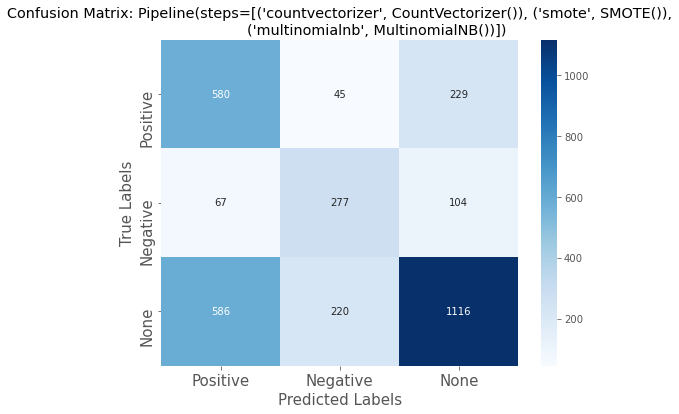

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.68      0.56       854
           1       0.51      0.62      0.56       448
           2       0.77      0.58      0.66      1922

    accuracy                           0.61      3224
   macro avg       0.58      0.63      0.59      3224
weighted avg       0.65      0.61      0.62      3224



(None, None)

In [329]:
plot_cm_senti(mnb_pipe_count, y_val, y_hat), classify(y_val, y_hat)

## Observations


### Class "Positive":
- Precision: 0.47 - The model correctly identifies positive tweets 47% of the time among all predicted positive tweets.
- Recall: 0.67 - The model captures only 67% of actual positive tweets among all actual positive tweets.


### Class "Negative":
- Precision: 0.50 - The model correctly identifies negative tweets 50% of the time among all predicted negative tweets.
- Recall: 0.62 - The model captures only 62% of actual negative tweets among all actual negative tweets.


### Class "No Emotion":
- Precision: 0.77 - The model correctly identifies tweets with no emotion 77% of the time among all predicted no emotion tweets.
- Recall: 0.58 - The model captures 58% of actual no emotion tweets among all actual no emotion tweets.

- Accuracy:
- Overall accuracy: 0.61 - The model's predictions are correct for 61% of all tweets.

## Analysis:

The model performs reasonably well for the "No Emotion" class, with a high recall, precision, and F1-Score. This indicates that the model is effective at identifying tweets with no discernible sentiment.
However, the model struggles with the "Positive" and "Negative" classes, as indicated by low recall. This suggests that the model has difficulty distinguishing between these sentiment classes.

## MNB 2: Tfidf Vectorizer

In [330]:
mnb = MultinomialNB()

mnb_pipe_tf = make_pipeline(TfidfVectorizer(),\
                         SMOTE(),\
                         mnb)

mnb_pipe_tf.fit(X_t, y_t)
y_hat = mnb_pipe_tf.predict(X_val)
accuracy_score(y_val, y_hat)

0.5946029776674938

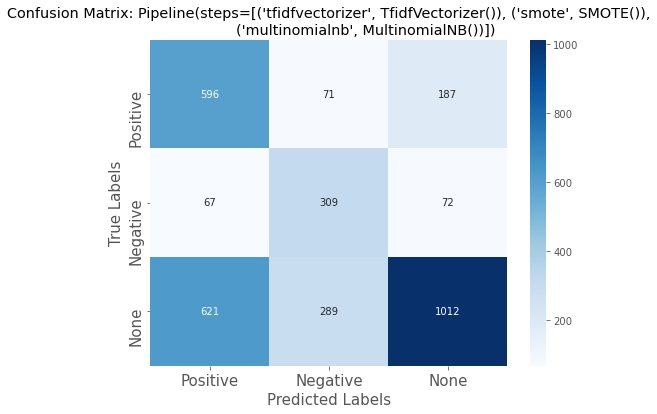

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.70      0.56       854
           1       0.46      0.69      0.55       448
           2       0.80      0.53      0.63      1922

    accuracy                           0.59      3224
   macro avg       0.57      0.64      0.58      3224
weighted avg       0.66      0.59      0.60      3224



(None, None)

In [332]:
plot_cm_senti(mnb_pipe_tf, y_val, y_hat), classify(y_val, y_hat)

## Observations


### Class "Positive":
- Precision: 0.47 - The model correctly identifies positive tweets 47% of the time among all predicted positive tweets.
- Recall: 0.70 - The model captures only 70% of actual positive tweets among all actual positive tweets.


### Class "Negative":
- Precision: 0.47 - The model correctly identifies negative tweets 47% of the time among all predicted negative tweets.
- Recall: 0.71 - The model captures only 71% of actual negative tweets among all actual negative tweets.


### Class "No Emotion":
- Precision: 0.80 - The model correctly identifies tweets with no emotion 80% of the time among all predicted no emotion tweets.
- Recall: 0.53 - The model captures 53% of actual no emotion tweets among all actual no emotion tweets.

- Accuracy:
- Overall accuracy: 0.60 - The model's predictions are correct for 60% of all tweets.

## Analysis:

The model performs reasonably well for the "No Emotion" class, with a high recall, precision, and F1-Score. This indicates that the model is effective at identifying tweets with no discernible sentiment.
However, the model struggles with the "Positive" and "Negative" classes, as indicated by low recall and F1-Scores. This suggests that the model has difficulty distinguishing between these sentiment classes.

## Iteration 2: XGBoost Pipeline
XGBoost (eXtreme Gradient Boosting) is a powerful and widely used machine learning algorithm designed for supervised learning tasks, including both classification and regression problems. It is an implementation of the gradient boosting framework that has gained popularity due to its exceptional performance and scalability.

The purpose of XGBoost is to create an accurate and robust predictive model by combining multiple weak predictive models, typically decision trees. Here are some key purposes and advantages of using XGBoost:

- `High Prediction Accuracy`: XGBoost is known for its exceptional accuracy and predictive power. It leverages gradient boosting techniques to iteratively train a series of weak learners (decision trees) that sequentially correct the mistakes made by the previous models. This iterative process allows XGBoost to capture complex relationships within the data, resulting in improved predictive performance.

- `Handling Complex Data Patterns`: XGBoost can effectively handle complex data patterns, including non-linear relationships and interactions between features. The algorithm can automatically capture and model these intricate relationships through the ensemble of decision trees, making it a suitable choice for a wide range of machine learning problems.

- `Regularization and Control over Model Complexity`: XGBoost provides various regularization techniques to control the complexity of the model and prevent overfitting. Regularization methods, such as L1 and L2 regularization, can be applied to the model's weights or the structure of the decision trees. This helps prevent the model from becoming too complex and provides a way to balance between overfitting and underfitting.

- `Feature Importance Analysis`: XGBoost offers built-in methods to assess the importance of features in the predictive model. By examining the contribution of each feature in the ensemble of decision trees, you can gain insights into the most influential features for making predictions. This analysis aids in feature selection, understanding the underlying data, and interpreting the model's behavior.

- `Scalability and Efficiency`: XGBoost is designed to be highly scalable and efficient, enabling it to handle large datasets and perform computations in parallel. The algorithm includes optimizations such as parallel tree construction, approximate algorithms for split finding, and efficient memory usage. These features make XGBoost suitable for both small and large-scale machine learning tasks.

- `Flexibility and Customization`: XGBoost offers a wide range of hyperparameters that can be tuned to optimize the model's performance for specific tasks. You can adjust parameters related to the tree structure, learning rate, regularization, and more. This flexibility allows you to customize the algorithm to suit your specific needs and achieve the best results.

## XGB 1: Count Vectorizer

In [157]:
import xgboost as xgb
from xgboost import XGBClassifier

xgb_pipe = XGBClassifier(random_state=42,max_depth = 15, tree_method='hist', n_estimators = 50,n_jobs = -1)

xgb_pipe_count = make_pipeline(CountVectorizer(),\
                         SMOTE(),\
                         xgb_pipe)

xgb_pipe_count.fit(X_t, y_t)
y_hat = xgb_pipe_count.predict(X_val)
accuracy_score(y_val, y_hat)

0.6876550868486352

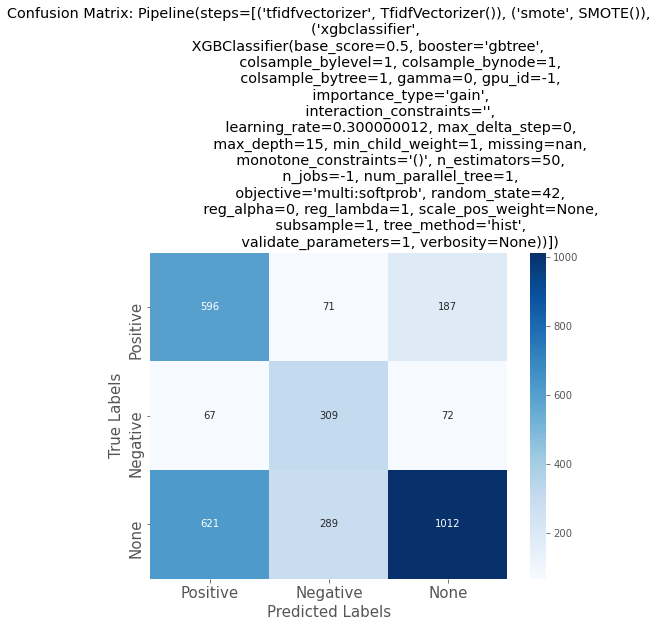

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.70      0.56       854
           1       0.46      0.69      0.55       448
           2       0.80      0.53      0.63      1922

    accuracy                           0.59      3224
   macro avg       0.57      0.64      0.58      3224
weighted avg       0.66      0.59      0.60      3224



(None, None)

In [333]:
plot_cm_senti(xgb_pipe_count, y_val, y_hat), classify(y_val, y_hat)

## Precision, Recall:

### Class "positive":
- Precision: 0.64 - The model correctly identifies positive tweets 64% of the time among all predicted positive tweets.
- Recall: 0.44 - The model captures 44% of actual positive tweets among all actual positive tweets.


### Class "negative":
- Precision: 0.63 - The model correctly identifies negative tweets 63% of the time among all predicted negative tweets.
- Recall: 0.46 - The model captures 46% of actual negative tweets among all actual negative tweets.

### Class "no emotion":
- Precision: 0.71 - The model correctly identifies tweets with no emotion 71% of the time among all predicted no emotion tweets.
- Recall: 0.85 - The model captures 85% of actual no emotion tweets among all actual no emotion tweets.


### Accuracy:
- Overall accuracy: 0.69 - The model's predictions are correct for 69% of all tweets.


The model has shown improvement in terms of precision, recall, and F1-Scores for all classes compared to the previous report. It's now performing more consistently across different sentiment categories.
The "No Emotion" class continues to have the highest recall and F1-Score, indicating that the model is effective at identifying tweets with no discernible sentiment.
The "Positive" and "Negative" classes have similar precision, recall, and F1-Scores, suggesting that the model is becoming better at distinguishing between these sentiment classes.

## XGB 2: Tfidf Vectorizer

In [334]:
xgb_pipe = XGBClassifier(random_state=42,max_depth = 15, tree_method='hist', n_estimators = 50,n_jobs = -1)

xgb_pipe_count = make_pipeline(TfidfVectorizer(),\
                         SMOTE(),\
                         xgb_pipe)

xgb_pipe_count.fit(X_t, y_t)
y_hat = xgb_pipe_count.predict(X_val)
accuracy_score(y_val, y_hat)

0.6696650124069479

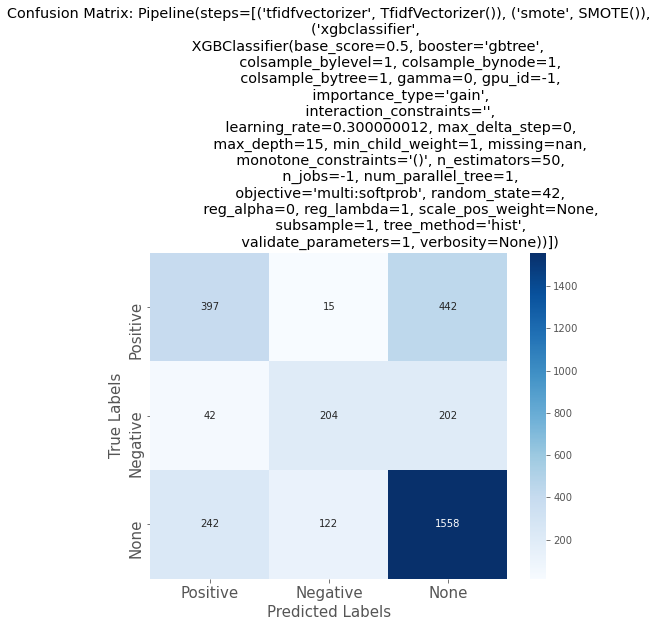

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.46      0.52       854
           1       0.60      0.46      0.52       448
           2       0.71      0.81      0.76      1922

    accuracy                           0.67      3224
   macro avg       0.63      0.58      0.60      3224
weighted avg       0.66      0.67      0.66      3224



(None, None)

In [336]:
plot_cm_senti(xgb_pipe_count, y_val, y_hat), classify(y_val, y_hat)

Precision, Recall, and F1-Score:

### Class "positive":
- Precision: 0.61 - The model correctly identifies positive tweets 61% of the time among all predicted positive tweets.
- Recall: 0.46 - The model captures 46% of actual positive tweets among all actual positive tweets.


### Class "negative":
- Precision: 0.60 - The model correctly identifies negative tweets 60% of the time among all predicted negative tweets.
- Recall: 0.46 - The model captures 46% of actual negative tweets among all actual negative tweets.

### Class "no emotion":
- Precision: 0.71 - The model correctly identifies tweets with no emotion 71% of the time among all predicted no emotion tweets.
- Recall: 0.83 - The model captures 83% of actual no emotion tweets among all actual no emotion tweets.


### Accuracy:
- Overall accuracy: 0.68 - The model's predictions are correct for 68% of all tweets.


The model has shown improvement in terms of precision, recall, and F1-Scores for all classes compared to the previous report. It's now performing more consistently across different sentiment categories.
The "No Emotion" class continues to have the highest recall and F1-Score, indicating that the model is effective at identifying tweets with no discernible sentiment.
The "Positive" and "Negative" classes have similar precision, recall, and F1-Scores, suggesting that the model is becoming better at distinguishing between these sentiment classes.

## Iteration 3: Random Forest Classifier

In [172]:
from sklearn.ensemble import RandomForestClassifier

forest_pipe = RandomForestClassifier(max_depth=20, random_state=42)

forest_pipe_count = make_pipeline(TfidfVectorizer(),\
                         SMOTE(),\
                         forest_pipe)

forest_pipe_count.fit(X_t, y_t)
y_hat = forest_pipe_count.predict(X_val)
accuracy_score(y_val, y_hat)

0.6386476426799007

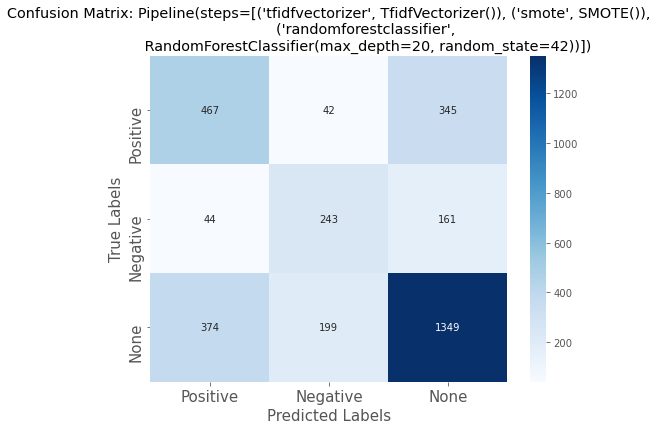

In [173]:
plot_cm_senti(forest_pipe_count, y_val, y_hat)

In [174]:
classify(y_val, y_hat)

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.55      0.54       854
           1       0.50      0.54      0.52       448
           2       0.73      0.70      0.71      1922

    accuracy                           0.64      3224
   macro avg       0.59      0.60      0.59      3224
weighted avg       0.64      0.64      0.64      3224



## Iteration 4: Grid Search with Cross Validation


## Using GridSearchCV
- `GridSearchCV` is a class in scikit-learn that performs an exhaustive search over a specified parameter grid to find the best hyperparameters for a given machine learning model. It is a technique for hyperparameter tuning, which involves finding the optimal combination of hyperparameters that maximizes the model's performance.

- `Cross-validation:` GridSearchCV performs cross-validation, which is a technique for evaluating the model's performance on multiple subsets of the training data. It splits the training data into multiple folds, trains the model on a subset of the folds, and evaluates its performance on the remaining fold. This process is repeated for each fold, and the results are averaged to get an overall performance estimate.


## Grid Search - MNB, Count Vectorizer

In [276]:
nb_count_pipe = make_pipeline(
    CountVectorizer(),
    SMOTE(random_state=42),
    MultinomialNB()
)

nb_count_grid = {
    'countvectorizer__max_features': [1000, 2000, 3000],
    'countvectorizer__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]  # Alpha parameter for MultinomialNB
}

gs_nb_count = GridSearchCV(nb_count_pipe, nb_count_grid, cv=3)

In [277]:
gs_nb_count.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_features': [1000, 2000, 3000],
                         'countvectorizer__ngram_range': [(1, 1), (2, 2),
                                                          (3, 3)],
                         'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]})

In [278]:
y_pred_nb_count_train = gs_nb_count.predict(X_test)
accuracy_score(y_test, y_pred_nb_count_train)

0.5995657568238213

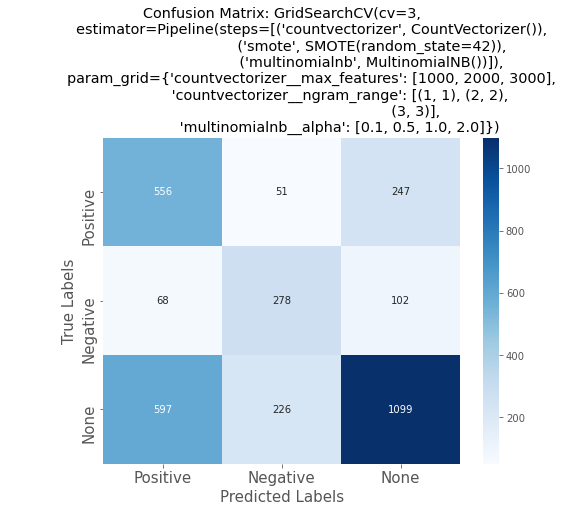

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       854
           1       0.50      0.62      0.55       448
           2       0.76      0.57      0.65      1922

    accuracy                           0.60      3224
   macro avg       0.57      0.61      0.58      3224
weighted avg       0.64      0.60      0.61      3224



(None, None)

In [284]:
plot_cm_senti(gs_nb_count, y_test, y_pred_nb_count_train), classify(y_test, y_pred_nb_count_train)

## Testing model on validation set

In [285]:
gs_nb_count.fit(X_t, y_t)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'countvectorizer__max_features': [1000, 2000, 3000],
                         'countvectorizer__ngram_range': [(1, 1), (2, 2),
                                                          (3, 3)],
                         'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]})

In [289]:
y_pred_nb_count_val = gs_nb_count.predict(X_val)
accuracy_score(y_val, y_pred_nb_count_val)

0.5995657568238213

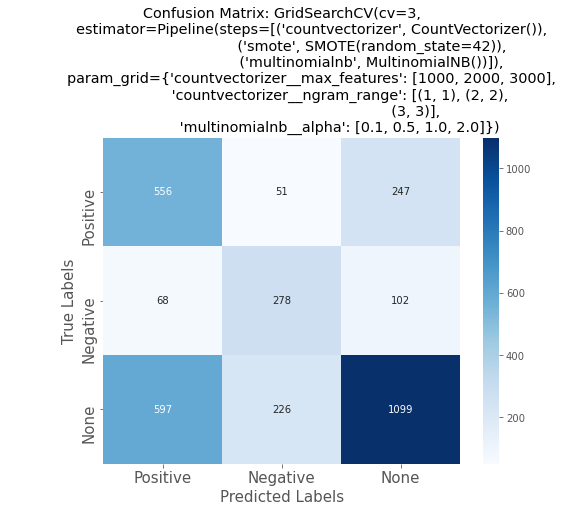

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.65      0.54       854
           1       0.50      0.62      0.55       448
           2       0.76      0.57      0.65      1922

    accuracy                           0.60      3224
   macro avg       0.57      0.61      0.58      3224
weighted avg       0.64      0.60      0.61      3224



(None, None)

In [290]:
plot_cm_senti(gs_nb_count, y_val, y_pred_nb_count_val), classify(y_val, y_pred_nb_count_val)

## Grid Search 2 - MNB, Tfidf

In [298]:
nb_tfidf_pipe = make_pipeline(TfidfVectorizer(),
                         SMOTE(random_state=42),
                         MultinomialNB()
)
nb_tfidf_pipe

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('smote', SMOTE(random_state=42)),
                ('multinomialnb', MultinomialNB())])

In [299]:
tfidf_grid = {
    'tfidfvectorizer__min_df': [1, 2],
    'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
    'tfidfvectorizer__ngram_range': [(1,1), (1,2), (2,2), (2,3), (3,3)],
    'tfidfvectorizer__norm': ('l1', 'l2'),
    'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0]   
}

In [300]:
gs_nb_tfidf = GridSearchCV(nb_tfidf_pipe, tfidf_grid, cv=3)

In [301]:
gs_nb_tfidf.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0],
                         'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
                         'tfidfvectorizer__min_df': [1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'tfidfvectorizer__norm': ('l1', 'l2')})

In [303]:
y_pred_nb_tfidf_train = gs_nb_tfidf.predict(X_test)
accuracy_score(y_test, y_pred_nb_tfidf_train)

0.658498759305211

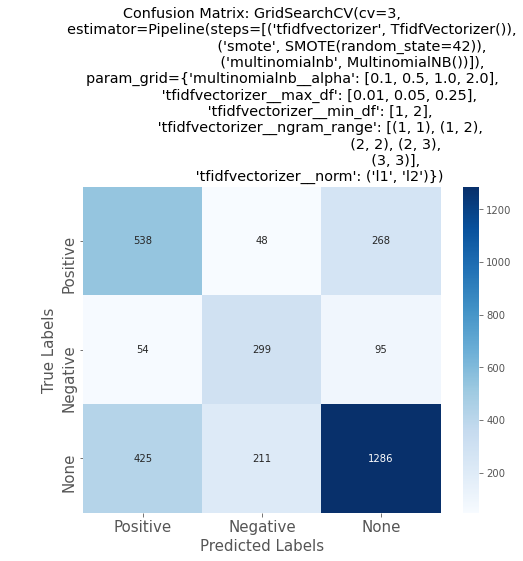

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.63      0.58       854
           1       0.54      0.67      0.59       448
           2       0.78      0.67      0.72      1922

    accuracy                           0.66      3224
   macro avg       0.61      0.66      0.63      3224
weighted avg       0.68      0.66      0.66      3224



(None, None)

In [304]:
plot_cm_senti(gs_nb_tfidf, y_val, y_pred_nb_tfidf_train), classify(y_val, y_pred_nb_tfidf_train)

## Testing Model on validation set

In [305]:
gs_nb_tfidf.fit(X_t, y_t)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('smote', SMOTE(random_state=42)),
                                       ('multinomialnb', MultinomialNB())]),
             param_grid={'multinomialnb__alpha': [0.1, 0.5, 1.0, 2.0],
                         'tfidfvectorizer__max_df': [0.01, 0.05, 0.25],
                         'tfidfvectorizer__min_df': [1, 2],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (2, 2), (2, 3),
                                                          (3, 3)],
                         'tfidfvectorizer__norm': ('l1', 'l2')})

In [306]:
y_pred_nb_tfidf = gs_nb_tfidf.predict(X_val)
accuracy_score(y_val, y_pred_nb_tfidf)

0.658498759305211

In [307]:
y_pred_nb_tfidf = gs_nb_tfidf.predict(X_test)
accuracy_score(y_val, y_pred_nb_tfidf)

0.658498759305211

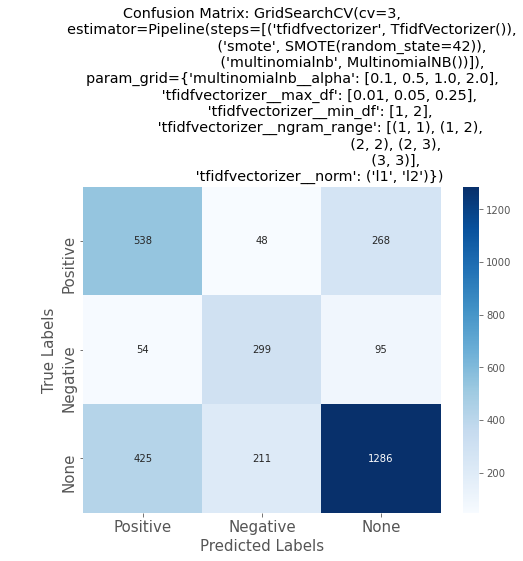

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.63      0.58       854
           1       0.54      0.67      0.59       448
           2       0.78      0.67      0.72      1922

    accuracy                           0.66      3224
   macro avg       0.61      0.66      0.63      3224
weighted avg       0.68      0.66      0.66      3224



(None, None)

In [308]:
plot_cm_senti(gs_nb_count, y_val, y_pred_nb_tfidf), classify(y_val, y_pred_nb_tfidf)

In [309]:
# Access the detailed results
cv_results = gs_nb_tfidf.cv_results_

# Print the scores for each fold and parameter combination
for i in range(len(cv_results['params'])):
    print(f"Parameters: {cv_results['params'][i]}")
    for fold in range(gs_nb_tfidf.n_splits_):
        print(f"Fold {fold + 1}: Mean test score = {cv_results[f'split{fold}_test_score'][i]:.4f}")

Parameters: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_df': 0.01, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__norm': 'l1'}
Fold 1: Mean test score = 0.5729
Fold 2: Mean test score = 0.5518
Fold 3: Mean test score = 0.5623
Parameters: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_df': 0.01, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 1), 'tfidfvectorizer__norm': 'l2'}
Fold 1: Mean test score = 0.5726
Fold 2: Mean test score = 0.5524
Fold 3: Mean test score = 0.5583
Parameters: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_df': 0.01, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__norm': 'l1'}
Fold 1: Mean test score = 0.5927
Fold 2: Mean test score = 0.5968
Fold 3: Mean test score = 0.5958
Parameters: {'multinomialnb__alpha': 0.1, 'tfidfvectorizer__max_df': 0.01, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__norm': 'l2'}

In [311]:
gs_nb_tfidf.best_estimator_

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_df=0.25, ngram_range=(1, 2), norm='l1')),
                ('smote', SMOTE(random_state=42)),
                ('multinomialnb', MultinomialNB(alpha=0.1))])

## Best Model - Gridsearch with Multinomial Bayes, Tfidf Vectorizer and SMOTE

After many iterations, the Multinomial Bayes model has proved to be the best model. This model although not performing the highest in accuracy overall has the best results with positive and negative tweets, without losing too much accuracy on the neutral tweets. Predictions on the rest of the model did a great job on neutral tweets, but was lacking in identifying negative tweets, which was the goal of this study. Overall this model also only lost a mere 3% on the overall accuracy compared to the XGboost model. 

## Conclusion

- When finding a model for predicting the sentiment of a tweet, the multinomial bayes using gridsearch cross validation showed the best recall for learning how to maximize false negatives. 

- The random forest model performed at a 66% accuracy

- For class 0 (positive), a recall of 0.63 indicates that the classifier correctly identified 63% of the actual positive instances. In other words, 63% of the tweets that were positive were correctly classified as positive.

- For class 1 (negative), a recall of 0.67 indicates that the classifier correctly identified 67% of the actual negative instances. In other words, 67% of the tweets that were negative were correctly classified as negative.

- For class 2 (neutral), a recall of 0.67 indicates that the classifier correctly identified 67% of the actual neutral instances. In other words, 67% of the tweets that were neutral were correctly classified as neutral.

# Recommendations

## For positive sentiment:
- look for tweets containing these key words or phrases:
    - 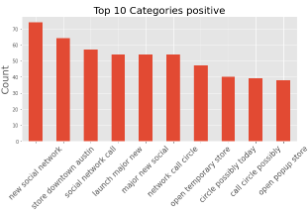
## For Negative sentiment:
- look for tweets containig these key words or phrases:
    - 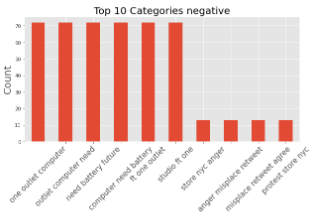

# Future Work

Moving forward, some essential moves that will be needed in order to improve the model and business usage will be to increase the data sample and find one that is more balanced. The companies that may be interested in this will also want to look at tweets by product as well to focus more on which products are producing the worst or best sentiment and may be the leader in affecting stock prices by tweets.